#### importing required Libraries

In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import re
import seaborn as sns
%matplotlib inline

!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer

!pip install wordcloud
from wordcloud import WordCloud

!pip install tweet-preprocessor
import preprocessor as p

from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


2023-01-04 19:13:48.352484: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-04 19:13:48.352499: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Defining Column names and encoding to give the data columna and Encoding type

In [3]:
encoding = 'ISO-8859-1'
col_names = ['target', 'id', 'date', 'flag', 'user', 'text']

dataset = pd.read_csv((r'training.1600000.processed.noemoticon.csv'), encoding=encoding, names=col_names)

In [4]:
print('Table 1')
dataset.head()

Table 1


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## EDA

In [5]:
import copy
#creating copy of data for EDA
data = copy.deepcopy(dataset)

In [6]:
#creating positive and negative dataset
positive_data = data[data.target == 4].iloc[:80000, :]
negative_data = data[data.target == 0].iloc[:80000, :]
#creating dataframe combining 
sub_data = pd.concat([positive_data, negative_data], axis=0)

### bosxplotting for checking outliers

Boxplotting targeting to check if there is any outliers..


<AxesSubplot:>

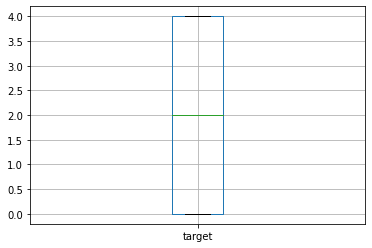

In [7]:
print('Boxplotting targeting to check if there is any outliers..')
data.boxplot(column='target')

In [8]:
data_ = {'target': data.target, 'date': data['date']}
df = pd.DataFrame(data_)
df

,target,date
0,0,Mon Apr 06 22:19:45 PDT 2009
1,0,Mon Apr 06 22:19:49 PDT 2009
2,0,Mon Apr 06 22:19:53 PDT 2009
3,0,Mon Apr 06 22:19:57 PDT 2009
4,0,Mon Apr 06 22:19:57 PDT 2009
...,...,...
1599995,4,Tue Jun 16 08:40:49 PDT 2009
1599996,4,Tue Jun 16 08:40:49 PDT 2009
1599997,4,Tue Jun 16 08:40:49 PDT 2009
1599998,4,Tue Jun 16 08:40:49 PDT 2009


In [9]:
#converting time object to date-time-datatype
df['date'] = pd.to_datetime(df['date'])

/home/dingo/.local/lib/python3.10/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [10]:
hour = [ df['date'][i].hour for i in range(len(df['date'])) ]
df['hour'] = hour
print('Hour Chart')
df.head()

Hour Chart


,target,date,hour
0,0,2009-04-06 22:19:45,22
1,0,2009-04-06 22:19:49,22
2,0,2009-04-06 22:19:53,22
3,0,2009-04-06 22:19:57,22
4,0,2009-04-06 22:19:57,22


In [11]:
hour_data = {'0': [0]*24, '2': [0]*24, '4': [0]*24}
for i in range(len(df['hour'])):
    target = str(df['target'][i])
    hour = int(df['hour'][i])
    hour_data[target][hour] += 1

In [12]:
#creating list datatype to store hour_data to plot
hour_data = [hour_data['0'], hour_data['2'], hour_data['4']]
hour_data = list(map(list,zip(*hour_data)))

In [13]:
df1 = pd.DataFrame(hour_data,index = [i for i in range(24)],columns=['negative', 'neutral', 'positive'])

Plotting positive, negative and neutral in a line chart.


<AxesSubplot:>

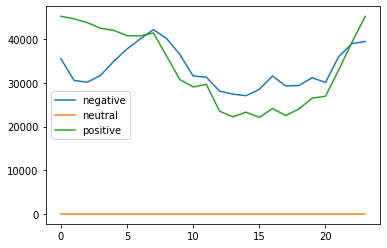

In [14]:
print('Plotting positive, negative and neutral in a line chart.')
df1.plot()

### Preprocessing

In [15]:
#copying from dataset to preprocessing
df = dataset.copy().sample(8000, random_state=42)
df["label"] = 0
df = df[['text', 'label']]
df.dropna(inplace=True)
df.head()

,text,label
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,0
750,"@misstoriblack cool , i have no tweet apps fo...",0
766711,@TiannaChaos i know just family drama. its la...,0
285055,School email won't open and I have geography ...,0
705995,upper airways problem,0


In [16]:
col_names = ['id', 'text']
df2 = pd.read_csv('depressive_tweets_processed.csv', sep = '|', header = None, usecols = [0,5], nrows = 3200, names=col_names)

In [17]:
df2['label'] = 1
df2 = df2[['text', 'label']]

In [18]:
col_names = ['id', 'text']
df2 = pd.read_csv('depressive_tweets_processed.csv', sep = '|', header = None, usecols = [0,5], nrows = 3200, names=col_names)

In [19]:
df = pd.concat([df,df2]) # merge the dataset on normal tweets and depressive tweets
df = df.sample(frac=1)  # shuffle the dataset

In [20]:
#creating contractions to contract text
contractions = pd.read_json( 'contraction.json', typ='series')
contractions = contractions.to_dict()

In [21]:
c_re = re.compile('(%s)' % '|'.join(contractions.keys()))
#expanding contractions in the english dictionary
def expandContractions(text, c_re=c_re):
    def replace(match):
        return contractions[match.group(0)]
    return c_re.sub(replace, text)

In [22]:
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
#definimg text cleaning function
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        tweet = tweet.lower()
        tweet = BAD_SYMBOLS_RE.sub(' ', tweet)
        tweet = p.clean(tweet)
        
        #expand contraction
        tweet = expandContractions(tweet)

        #remove punctuation
        tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

        #stop words
        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet) 
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        tweet = ' '.join(filtered_sentence)
        
        cleaned_tweets.append(tweet)
        
    return cleaned_tweets

In [23]:
X = clean_tweets([tweet for tweet in df['text']])

In [24]:
#creating dataframe with depressive tweets after cleaning
depressive_tweets = [clean_tweets([t for t in df2['text']])]
depressive_words = ' '.join(list(map(str, depressive_tweets)))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)

Word Cloud


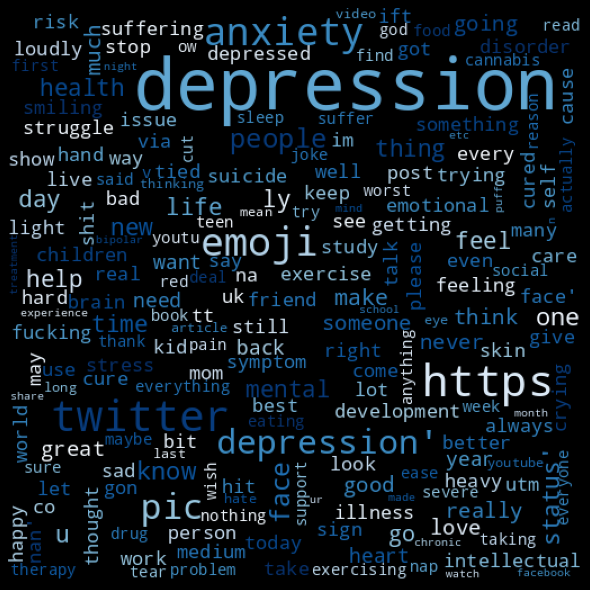

In [25]:
print('Word Cloud')
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [26]:
MAX_NUM_WORDS = 10000
#tokenizing the words
tokenizer= Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)

In [27]:
#converting them to vector
word_vector = tokenizer.texts_to_sequences(X)

In [28]:
word_index = tokenizer.word_index

In [29]:
vocab_size = len(word_index)
vocab_size  

20670

In [30]:

MAX_SEQ_LENGTH = 140
input_tensor = pad_sequences(word_vector, maxlen=MAX_SEQ_LENGTH)

In [31]:
input_tensor.shape

(10345, 140)

In [32]:
corpus = df['text'].values.astype('U')
#converting the corpus with vocab from the text into tfidf vectors
tfidf = TfidfVectorizer(max_features = MAX_NUM_WORDS) 
tdidf_tensor = tfidf.fit_transform(corpus)

In [33]:
tdidf_tensor.shape


(10345, 10000)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(tdidf_tensor, df['label'].values, test_size=0.3)

## Training Phase

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [36]:
baseline_model = SVC()
baseline_model.fit(x_train, y_train)

ValueError: Input y contains NaN.

In [ ]:
predictions = baseline_model.predict(x_test)

In [ ]:
accuracy_score(y_test, predictions)

0.9942010309278351

In [ ]:
print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.99335   0.99916   0.99625      2391
           1    0.99714   0.97756   0.98725       713

    accuracy                        0.99420      3104
   macro avg    0.99524   0.98836   0.99175      3104
weighted avg    0.99422   0.99420   0.99418      3104



In [ ]:
baseline_model2 = LogisticRegression()
baseline_model2.fit(x_train, y_train)

LogisticRegression()

In [ ]:
predictions = baseline_model2.predict(x_test)

In [ ]:
print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.98232   0.99916   0.99067      2391
           1    0.99702   0.93969   0.96751       713

    accuracy                        0.98550      3104
   macro avg    0.98967   0.96943   0.97909      3104
weighted avg    0.98570   0.98550   0.98535      3104



In [ ]:
baseline_model3 = RandomForestClassifier()
baseline_model3.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
predictions = baseline_model3.predict(x_test)

In [ ]:
print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.99749   0.99916   0.99833      2391
           1    0.99718   0.99158   0.99437       713

    accuracy                        0.99742      3104
   macro avg    0.99734   0.99537   0.99635      3104
weighted avg    0.99742   0.99742   0.99742      3104



In [ ]:
baseline_model4 = DecisionTreeClassifier()
baseline_model4.fit(x_train, y_train)

DecisionTreeClassifier()

In [ ]:
predictions = baseline_model4.predict(x_test)

In [ ]:
print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.99707   0.99749   0.99728      2391
           1    0.99157   0.99018   0.99088       713

    accuracy                        0.99581      3104
   macro avg    0.99432   0.99384   0.99408      3104
weighted avg    0.99581   0.99581   0.99581      3104



In [ ]:
baseline_model5 = MLPClassifier()
baseline_model5.fit(x_train, y_train)

MLPClassifier()

In [ ]:
predictions = baseline_model5.predict(x_test)

In [ ]:
print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.96803   0.98787   0.97785      2391
           1    0.95633   0.89060   0.92229       713

    accuracy                        0.96553      3104
   macro avg    0.96218   0.93924   0.95007      3104
weighted avg    0.96534   0.96553   0.96509      3104



In [ ]:
baseline_model6 = LogisticRegression(penalty='l2')
baseline_model6.fit(x_train, y_train)

LogisticRegression()

In [ ]:
predictions=baseline_model6.predict(x_test)

In [ ]:
print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.98232   0.99916   0.99067      2391
           1    0.99702   0.93969   0.96751       713

    accuracy                        0.98550      3104
   macro avg    0.98967   0.96943   0.97909      3104
weighted avg    0.98570   0.98550   0.98535      3104

